In [1]:
import pandas as pd
import pickle
import pdfplumber
from tqdm.notebook import tqdm
from util import *
from math import dist
from caption_extraction import *

In [2]:
samsung_image = pd.read_pickle('data/[삼성전자]사업보고서(2022.03.08)_image.pickle')
samsung_table = pd.read_pickle('data/[삼성전자]사업보고서(2022.03.08)_table.pickle')
samsung_text = pd.read_pickle('data/[삼성전자]사업보고서(2022.03.08)_text.pickle')

path = 'data/[삼성전자]사업보고서(2022.03.08).pdf'
file_name = path_to_name(path)
pdf = get_pdf(path)
pages = get_pages(pdf)

## Caption Detector

In [3]:
threshold_caption = 30 # 해당 텍스트가 표/이미지의 캡션에 해당하는지 아닌지 구분하는 threshold (거리)
threshold_chunk = 15 # 같은 줄에 있을 때 같은 chunk인지 아닌지 구분하는 threshold (거리)
threshold_line = 8 # 한 문장이 다음 줄로 이어지는 것인지 아닌지 구분하는 threshold (y값 거리)

In [ ]:
# 이미지에 대한 것도 추가 (일단 table에 대해서만 진행함)

for p in tqdm(range(len(pages))):
    if len(samsung_table[p]) != 0:
        table_data = samsung_table[p]
        text_data = samsung_text[p]
        table_bb_to_draw = []
        text_bb_to_draw = []

        for table in table_data:
            table_bb_to_draw.append(table['bbox'])
            caption_for_this_table = []

            i = 0
            while i < len(text_data):
                # print('loop 1:', i)

                # 특정 키워드를 포함 + table과의 거리가 threshold_caption 이내 + 텍스트가 표에 포함되지 않음(캡션의 시작점)
                if rect_distance(table['bbox'], get_bbox(text_data[i])) <= threshold_caption \
                and any(x in ['※', '*', '■', '☞', '[', '(', '<', '단위', '기준일', '주'] for x in text_data[i]['text']) \
                and contains(table['bbox'], get_bbox(text_data[i])) == False:
                    # print('detected start of caption')
                    caption_for_this_table.append(get_bbox(text_data[i]))
                    i += 1

                    while True:
                        # print('loop 2:', i)
                        # 앞 토큰과 같은 줄 + 거리가 threshold_chunk 이내
                        if get_bbox(text_data[i])[1] == get_bbox(text_data[i-1])[1] and get_bbox(text_data[i])[3] == get_bbox(text_data[i-1])[3] \
                        and rect_distance(get_bbox(text_data[i]), get_bbox(text_data[i-1])) <= threshold_chunk:
                            # print('case 1 - same line, same chunk')
                            caption_for_this_table.append(get_bbox(text_data[i]))
                            i += 1

                        # 줄이 바뀌지만 높이 차이가 threshold_line 이내 (이어지는 문장으로 판단)
                        elif diff_height(get_bbox(text_data[i]), get_bbox(text_data[i-1])) <= threshold_line:
                            # print('case 2 - different line, same chunk')
                            # print(get_bbox(text_data[i])[1], get_bbox(text_data[i-1])[1])
                            # print(get_bbox(text_data[i])[3], get_bbox(text_data[i-1])[3])
                            # print(rect_distance(get_bbox(text_data[i]), get_bbox(text_data[i-1])))
                            caption_for_this_table.append(get_bbox(text_data[i]))
                            i += 1

                        else:
                            # print('case 3 - end of caption')
                            i += 1
                            break
                else:
                    i += 1

            text_bb_to_draw.append(caption_for_this_table)

        im = pages[p].to_image(resolution=150)
        im.reset()
        for j in range(len(table_bb_to_draw)):
            im.draw_rect(table_bb_to_draw[j], fill=(255, 0, 0, 30))
            im.draw_rects(text_bb_to_draw[j])
        im.save(f'result/[삼성전자]사업보고서(2022.03.08)/{p+1}.png', format="PNG")

 79%|███████▉  | 452/569 [05:26<01:55,  1.01it/s]

In [404]:
len(table_bb_to_draw)

3

## Visualization for Test

In [352]:
for idx, text in enumerate(samsung_text[19]):
    if '단위' in text['text']: # ※☞
        print(idx)

53


table: (50.0, 267.0, 545.0, 483.0)
text: (356.8, 270.99, 376.8, 280.99)
text: (520.548, 247.9910000000001, 524.211, 258.9910000000001)
distance: 144.25
True


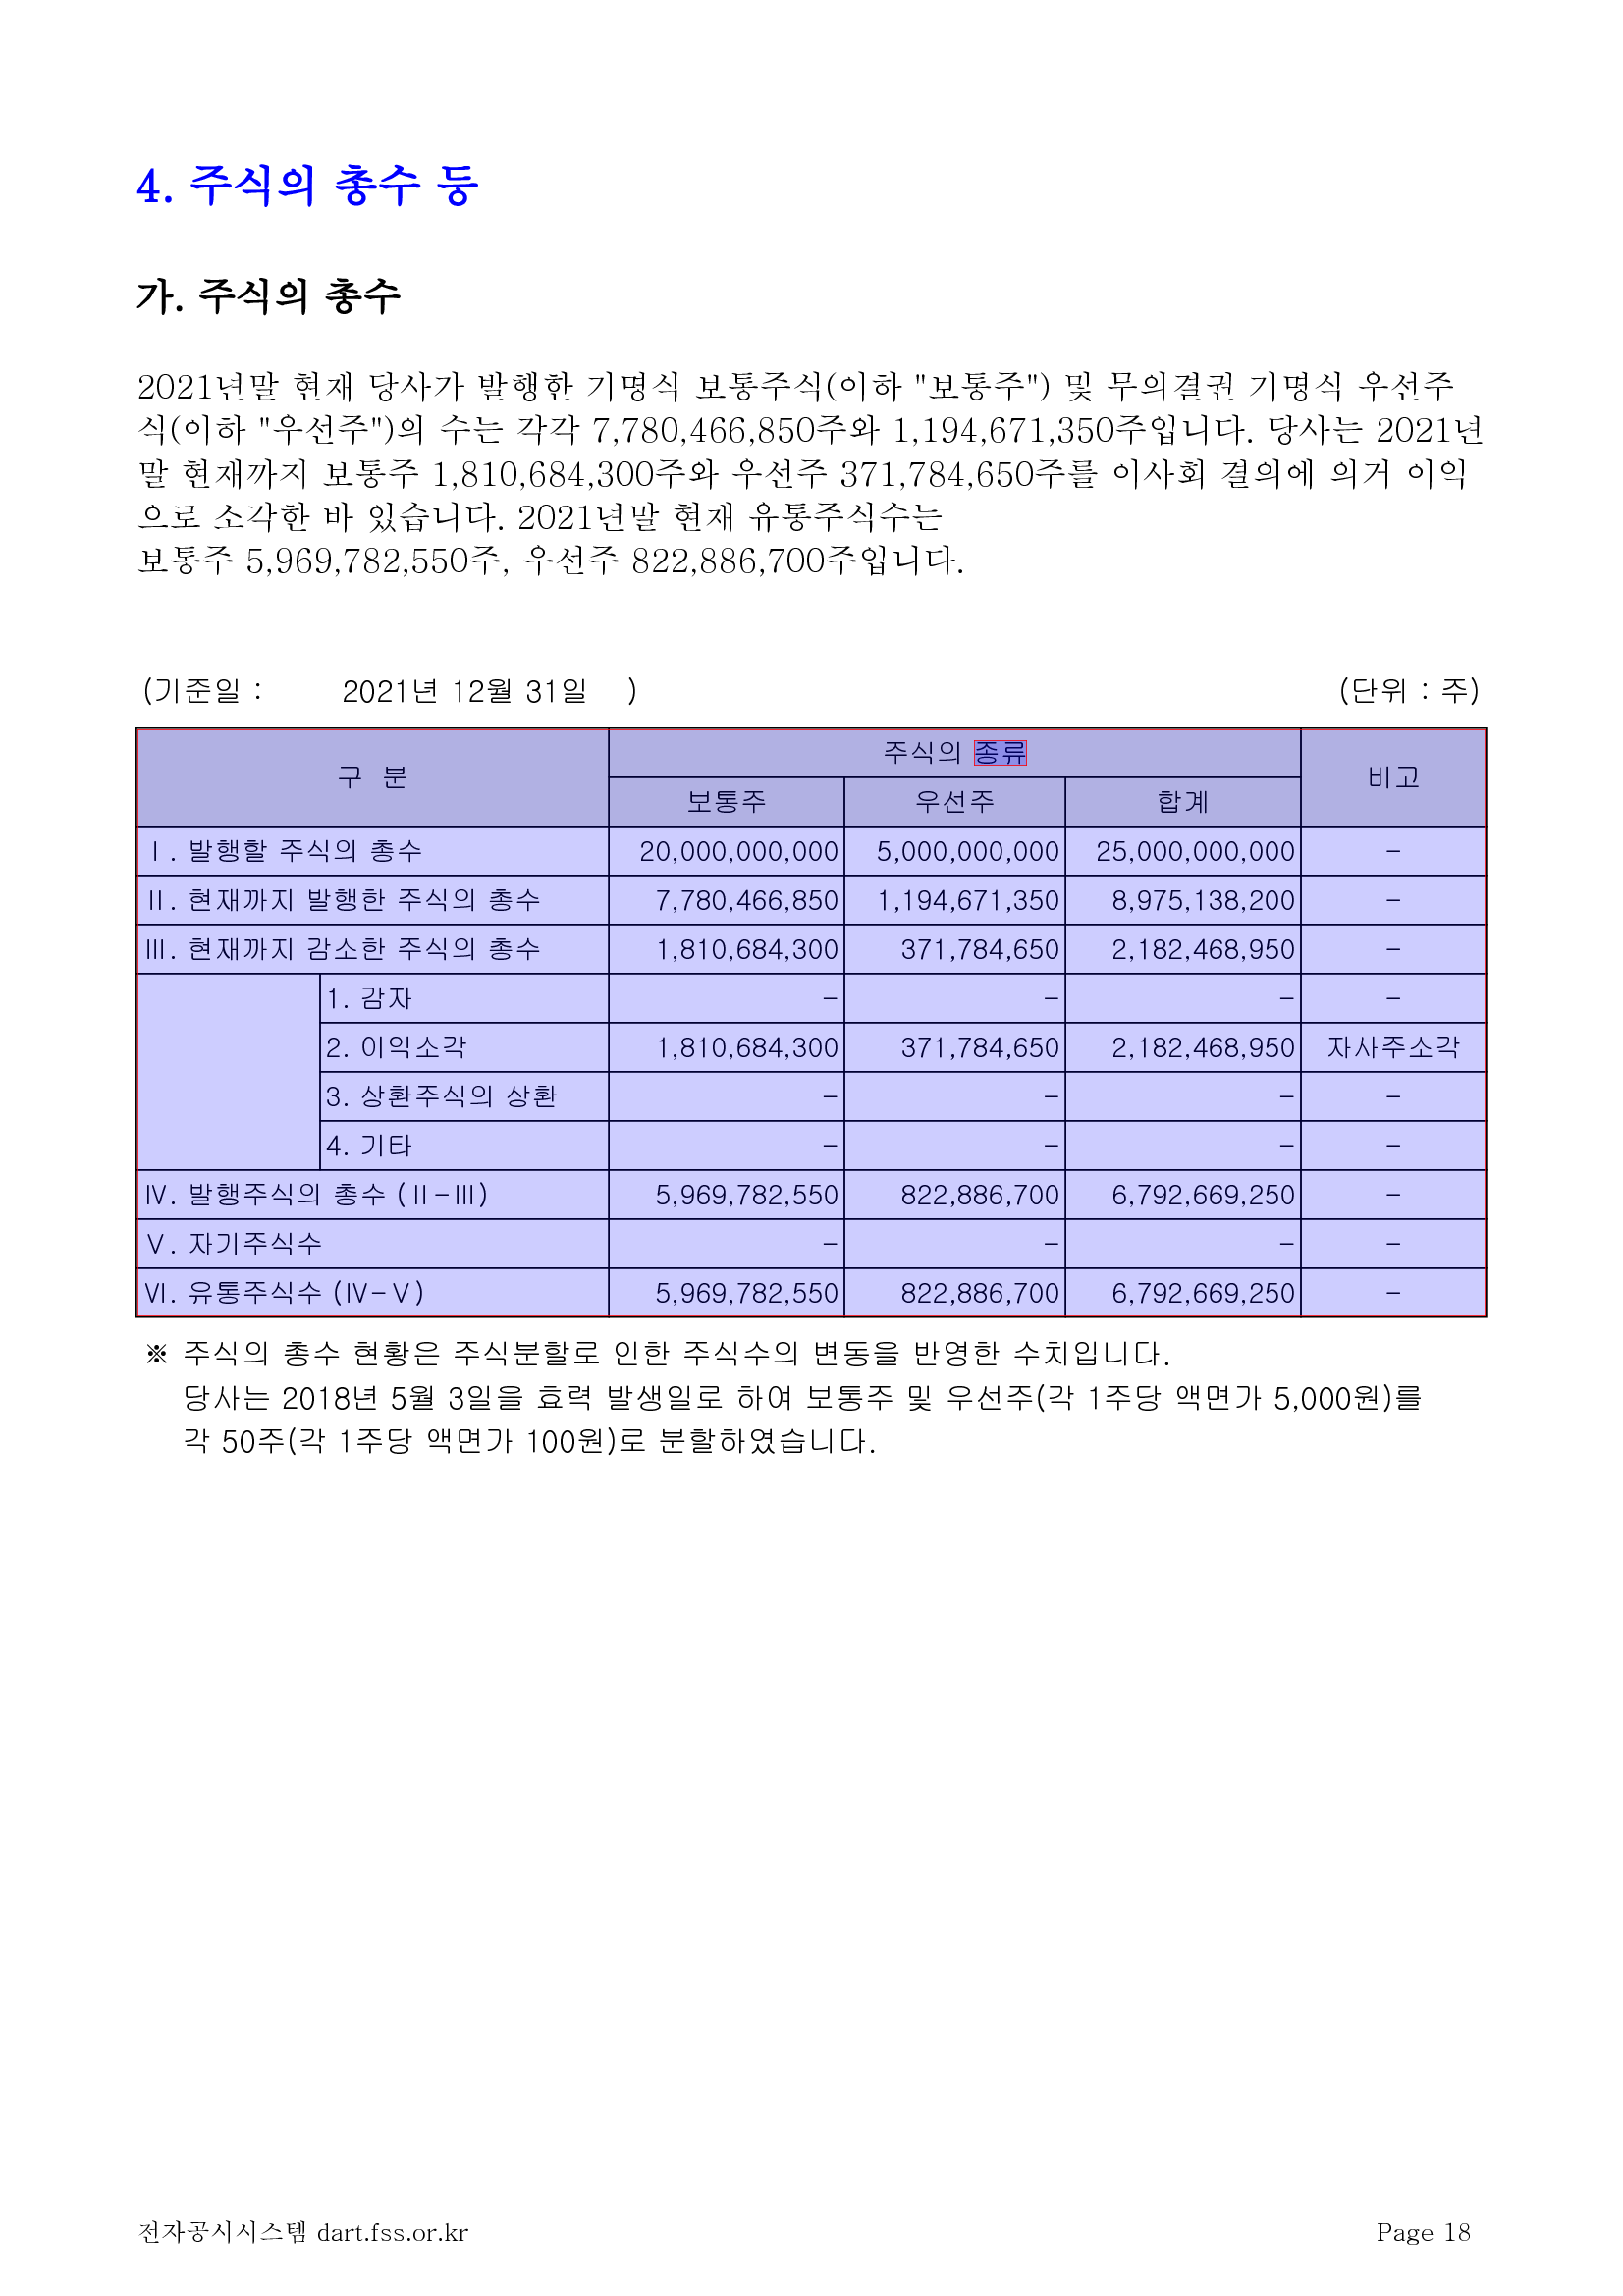

In [381]:
p = 19
i = 0 # table
j = 57 # text
k = 54 # text (sub)

table_list = [table['bbox'] for table in samsung_table[p]]
# text_list = [(round(text['x0'], 2), round(text['top'], 2), round(text['x1'], 2), round(text['bottom'], 2)) for text in samsung_text[p]]
text_list = [(text['x0'], text['top'], text['x1'], text['bottom']) for text in samsung_text[p]]

print('table:', table_list[i])
print('text:', text_list[j])
print('text:', text_list[k])
# print('distance:', round(rect_distance(table_list[i], text_list[j]), 2))
print('distance:', round(rect_distance(text_list[j], text_list[k]), 2))
# print('difference of height:', diff_height(text_list[j], text_list[k]))
# print(round(text_list[j][1], 2) == round(text_list[k][1], 2))
# print(round(text_list[j][3], 2) == round(text_list[k][3], 2))
print(contains(table_list[i], text_list[j]))

im = pages[p].to_image(resolution=200)
im.reset()
im.draw_rect(table_list[i])
im.draw_rect(text_list[j])
# im.draw_rect(text_list[k])

## Visualization

In [4]:
path = 'data/[삼성전자]사업보고서(2022.03.08).pdf'
file_name = path_to_name(path)
pdf = get_pdf(path)
pages = get_pages(pdf)

In [413]:
len(pages)

569

In [132]:
im = pages[10].to_image(resolution=150)

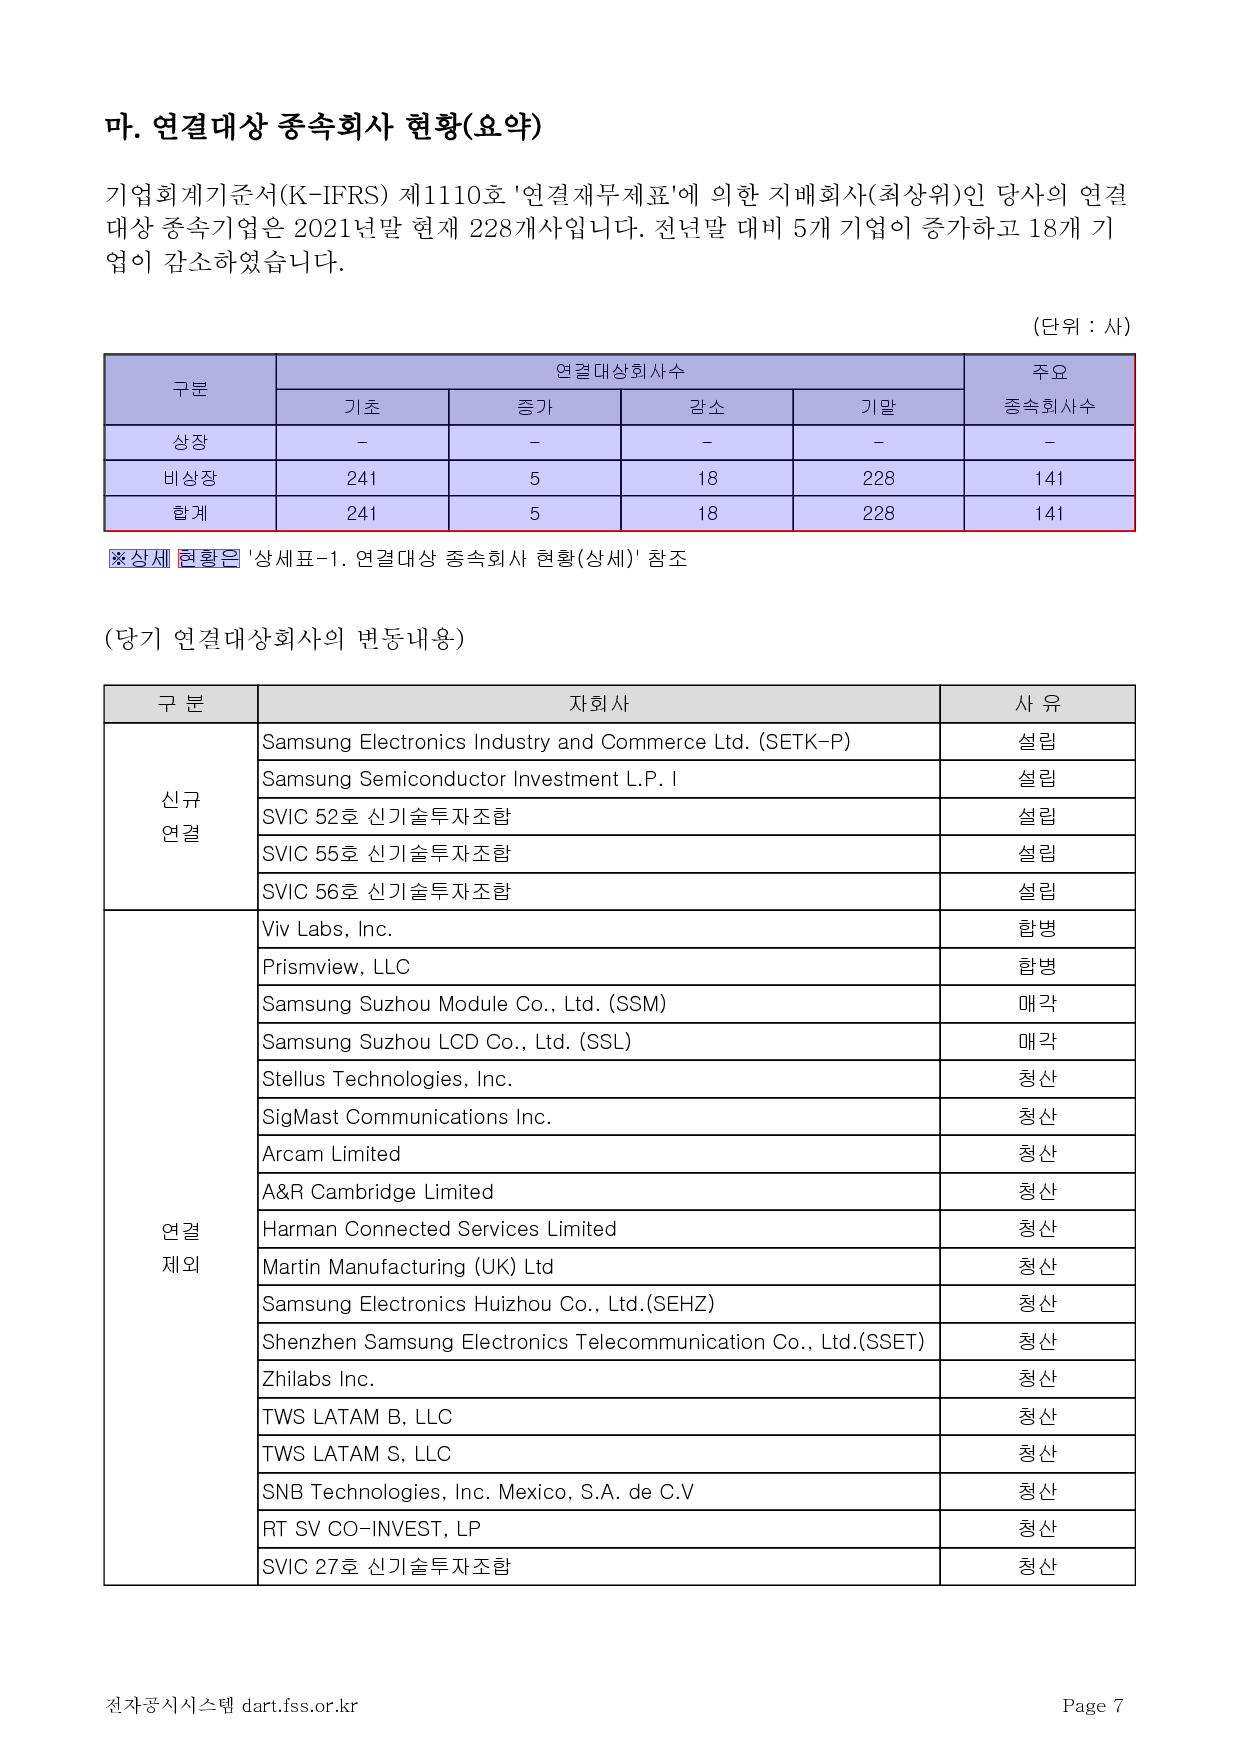

In [71]:
im.reset()
im.draw_rect((50.0, 170.0, 545.0, 255.0)) # table
im.draw_rect((52.0, 262.99, 82.0, 272.99)) # ※상세
im.draw_rect((85.33, 262.99, 115.33, 272.99)) # 현황은

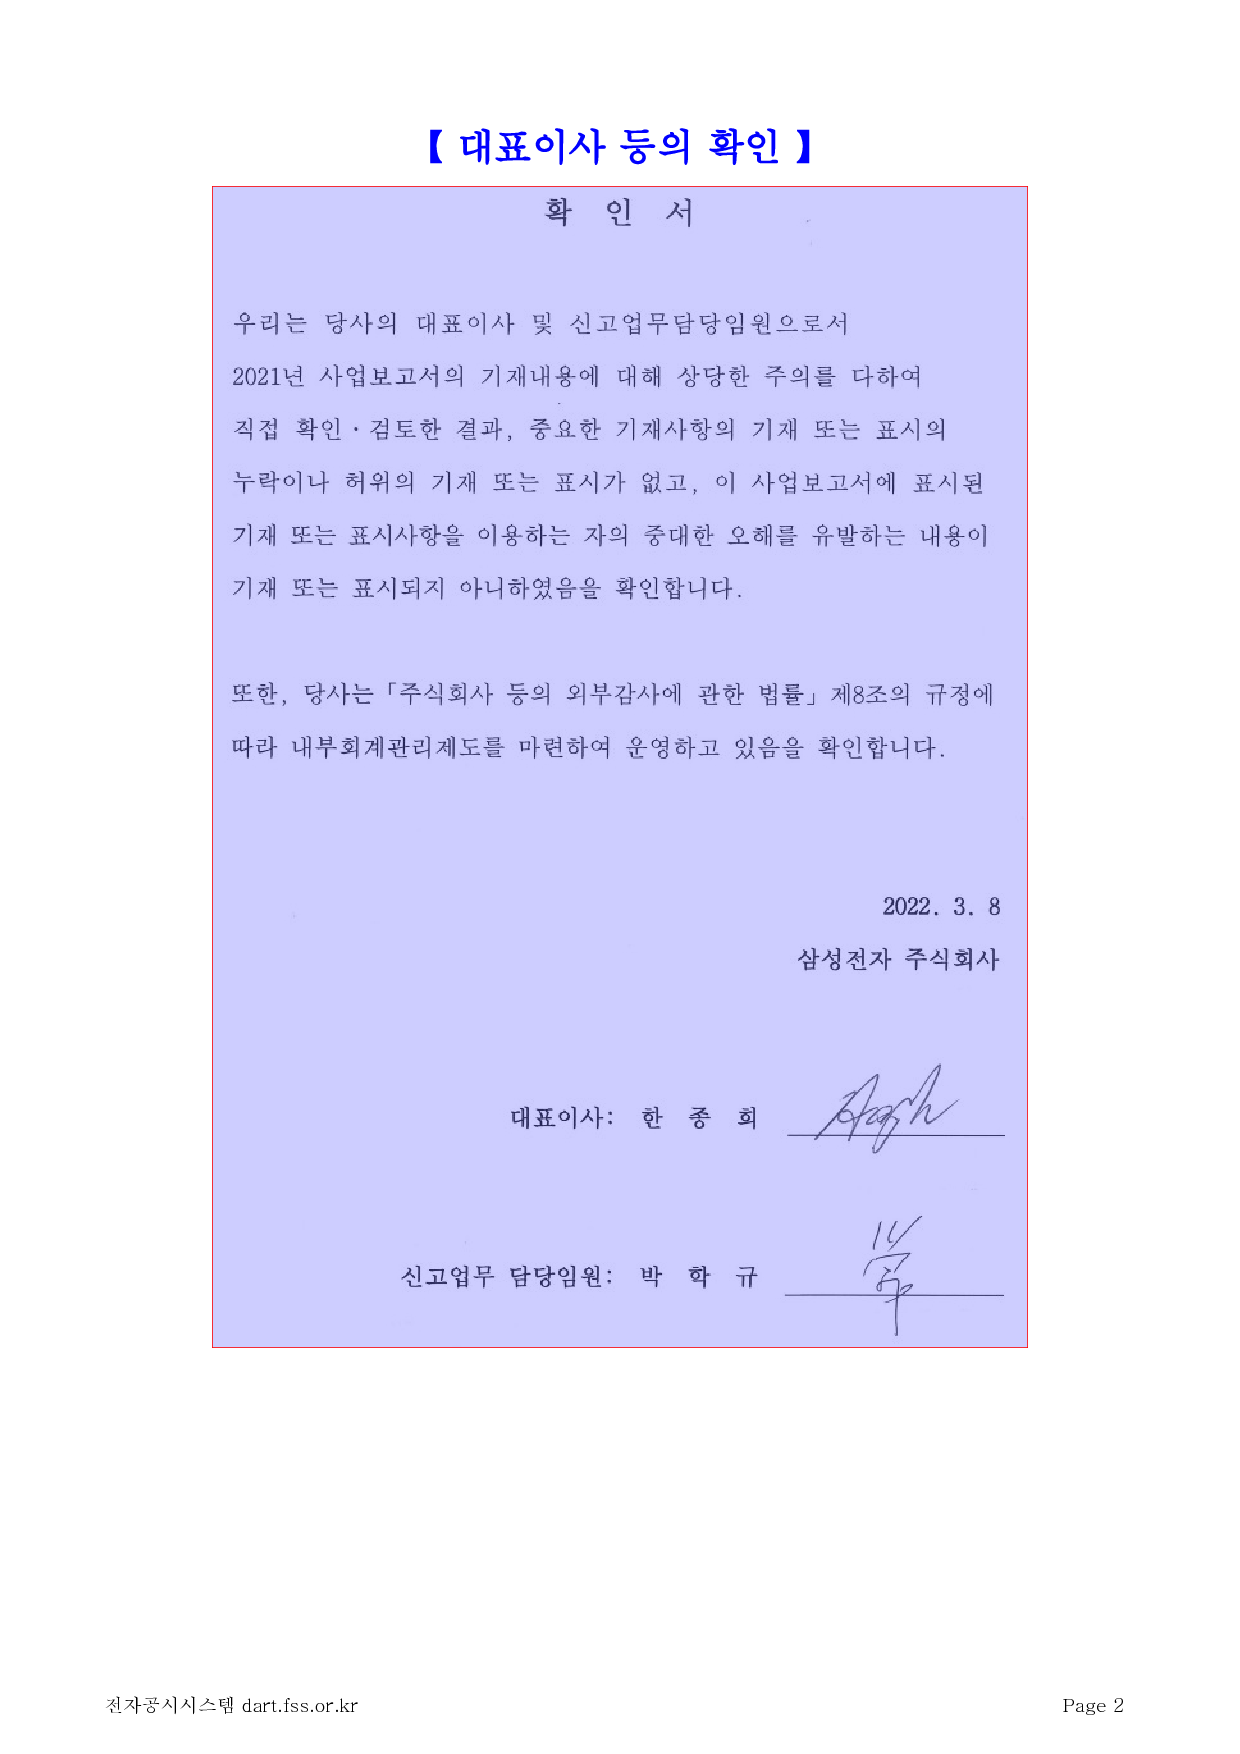

In [80]:
im = pages[3].to_image(resolution=150)
im.reset()
im.draw_rect((101.5, 89.0, 493.5, 646.89)) # image

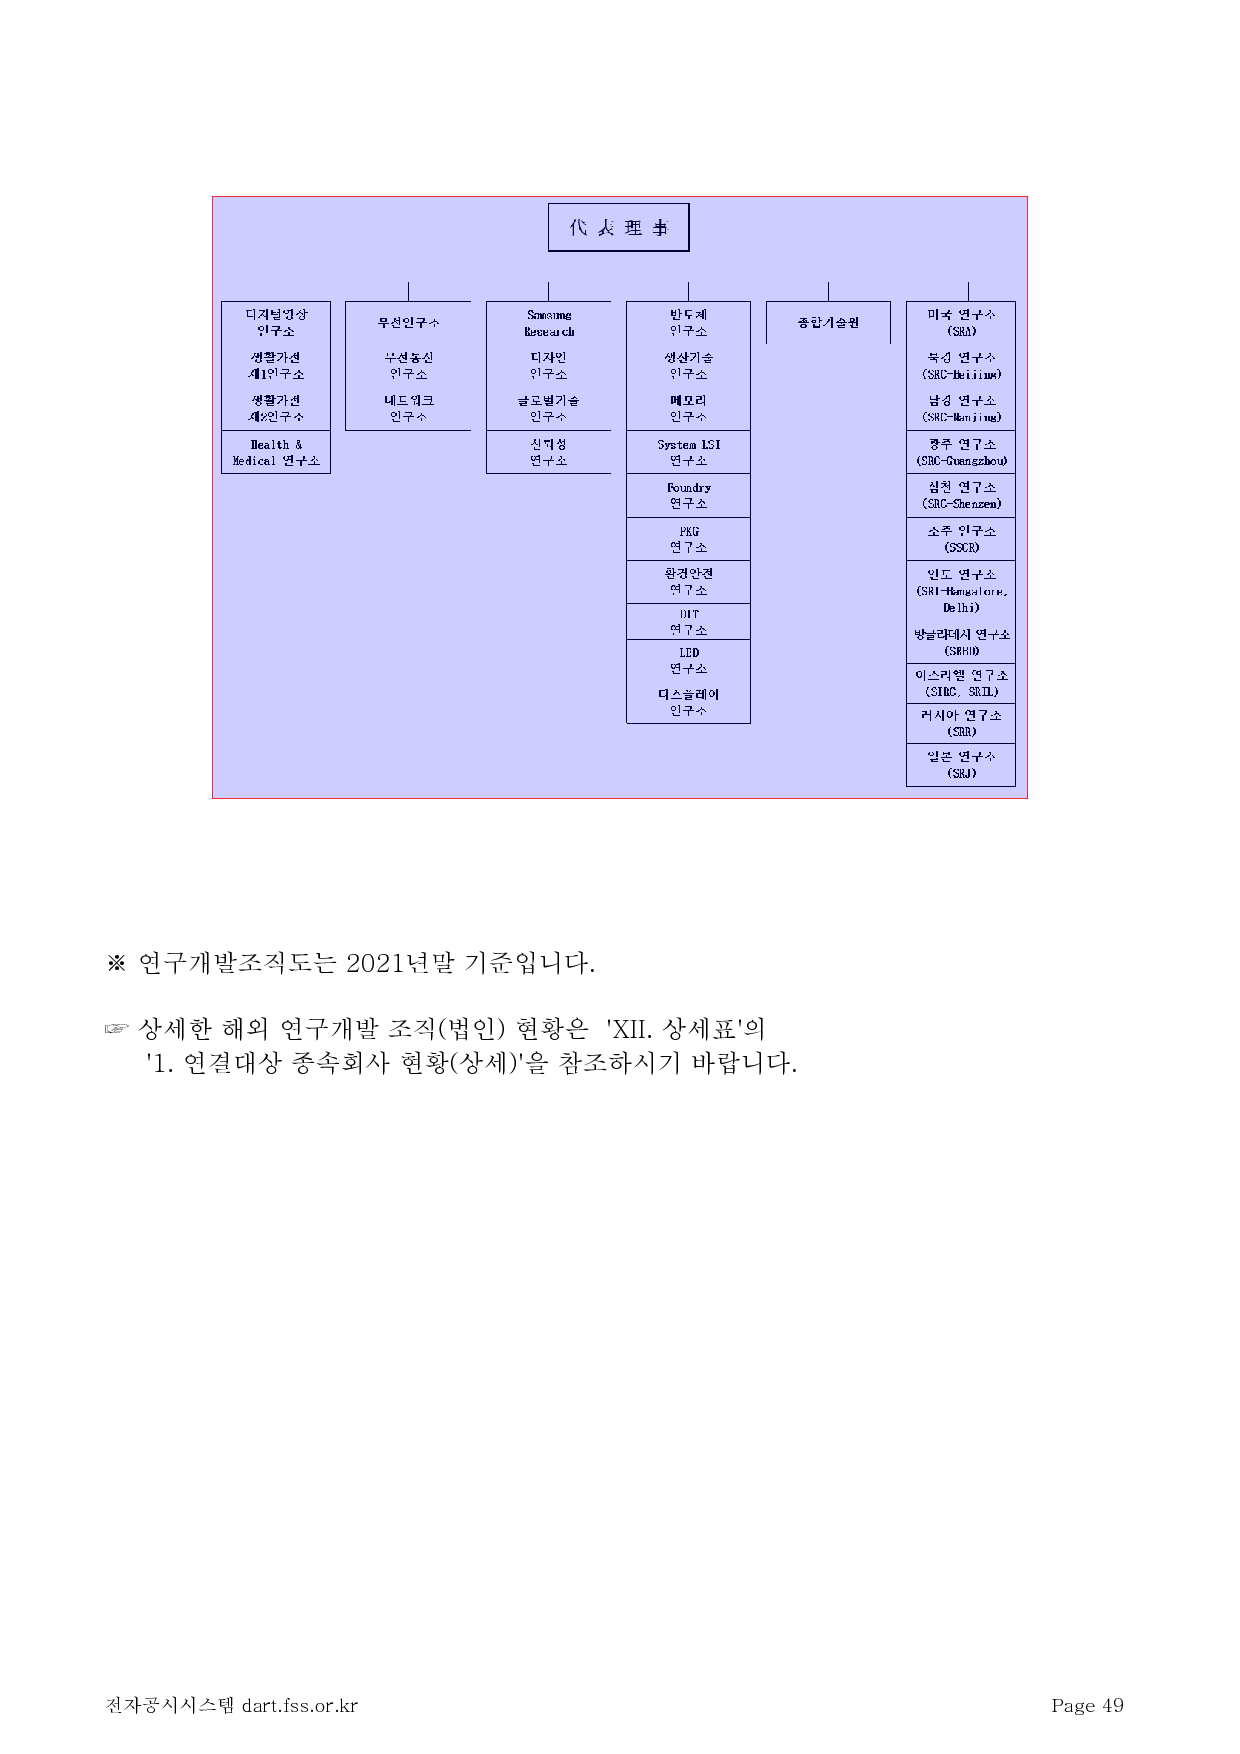

In [79]:
im = pages[50].to_image(resolution=150)
im.reset()
im.draw_rect((101.5, 94.0, 493.5, 383.65)) # image